# 公司財務健康度分析

本篇主要分析公司財務健康度，包含以下關鍵指標：

## 🎯 核心指標
1. **盈利能力指標** (40% 權重)
   - 營收成長率 (Revenue Growth Rate)
   - 毛利率 (Gross Profit Margin)
   - 淨利率 (Net Profit Margin)
   - 營業利益率 (Operating Margin)
   - 資產報酬率 (ROA)
   - 股東權益報酬率 (ROE)

2. **每股指標** (25% 權重)
   - 每股盈餘 (EPS)
   - EPS成長率 (EPS Growth Rate)
   - 每股淨值 (Book Value Per Share)

3. **現金流指標** (20% 權重)
   - 營運現金流 (Operating Cash Flow)
   - 自由現金流 (Free Cash Flow)
   - 現金流對淨利比 (OCF/Net Income)

4. **財務結構指標** (15% 權重)
   - 負債比 (Debt Ratio)
   - 流動比率 (Current Ratio)
   - 利息保障倍數 (Interest Coverage Ratio)

## 會使用到的 Library

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 導入產業分析模組
from company_health_analysis.industry_financial_analysis import IndustryFinancialAnalyzer
from company_health_analysis.industry_scoring_recommendations import IndustryScoringRecommendations

# 設定中文字體
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

# 初始化產業分析器
industry_analyzer = IndustryFinancialAnalyzer()
industry_scorer = IndustryScoringRecommendations()

print("✅ 模組載入完成")
print("📊 已載入產業分析功能")
print("🎯 支援科技業、金融業、製造業、零售業、公用事業等產業分析")

✅ 模組載入完成
📊 已載入產業分析功能
🎯 支援科技業、金融業、製造業、零售業、公用事業等產業分析


## 核心函數定義

### 1. 基礎數據獲取函數

In [2]:
def get_company_financial_data(stock_code, period="5y"):
    """
    獲取公司完整財務數據
    
    Parameters:
    stock_code (str): 股票代碼，例如 "2330.TW"
    period (str): 數據期間，預設為 "5y"
    
    Returns:
    dict: 包含各種財務數據的字典
    """
    try:
        # 建立股票物件
        stock = yf.Ticker(stock_code)
        
        # 獲取基本資訊
        info = stock.info
        
        # 獲取財務報表
        income_stmt = stock.financials  # 損益表 (年度)
        balance_sheet = stock.balance_sheet  # 資產負債表 (年度)
        cash_flow = stock.cashflow  # 現金流量表 (年度)
        
        # 獲取季度財務報表
        quarterly_income = stock.quarterly_financials  # 季度損益表
        quarterly_balance = stock.quarterly_balance_sheet  # 季度資產負債表
        quarterly_cashflow = stock.quarterly_cashflow  # 季度現金流
        
        # 獲取股價歷史數據
        stock_history = stock.history(period=period)
        
        return {
            'info': info,
            'income_statement': income_stmt,
            'balance_sheet': balance_sheet,
            'cash_flow': cash_flow,
            'quarterly_income': quarterly_income,
            'quarterly_balance': quarterly_balance,
            'quarterly_cashflow': quarterly_cashflow,
            'stock_history': stock_history,
            'stock_code': stock_code
        }
        
    except Exception as e:
        print(f"獲取 {stock_code} 數據時發生錯誤: {e}")
        return None

### 2. 財務健康度指標計算函數

In [3]:
def calculate_health_metrics(financial_data):
    """
    計算公司財務健康度指標
    
    Parameters:
    financial_data (dict): get_company_financial_data 返回的數據
    
    Returns:
    dict: 包含各項健康度指標的字典
    """
    
    metrics = {}
    info = financial_data['info']
    income_stmt = financial_data['income_statement']
    balance_sheet = financial_data['balance_sheet']
    cash_flow = financial_data['cash_flow']
    
    try:
        # === 盈利能力指標 ===
        
        # 1. 營收成長率 (最近一年 vs 前一年)
        if len(income_stmt.columns) >= 2:
            current_revenue = income_stmt.loc['Total Revenue'].iloc[0]
            previous_revenue = income_stmt.loc['Total Revenue'].iloc[1]
            metrics['revenue_growth_rate'] = ((current_revenue - previous_revenue) / previous_revenue) * 100
        else:
            metrics['revenue_growth_rate'] = None
            
        # 2. 毛利率 (直接從 info 或計算)
        metrics['gross_margin'] = info.get('grossMargins', None)
        if metrics['gross_margin'] is None and len(income_stmt.columns) >= 1:
            try:
                total_revenue = income_stmt.loc['Total Revenue'].iloc[0]
                cost_of_revenue = income_stmt.loc['Cost Of Revenue'].iloc[0]
                metrics['gross_margin'] = ((total_revenue - cost_of_revenue) / total_revenue) * 100
            except:
                metrics['gross_margin'] = None
        else:
            metrics['gross_margin'] = metrics['gross_margin'] * 100 if metrics['gross_margin'] else None
            
        # 3. 淨利率
        metrics['net_margin'] = info.get('profitMargins', None)
        if metrics['net_margin']:
            metrics['net_margin'] = metrics['net_margin'] * 100
            
        # 4. 營業利益率
        metrics['operating_margin'] = info.get('operatingMargins', None)
        if metrics['operating_margin']:
            metrics['operating_margin'] = metrics['operating_margin'] * 100
            
        # 5. ROA (資產報酬率)
        metrics['roa'] = info.get('returnOnAssets', None)
        if metrics['roa']:
            metrics['roa'] = metrics['roa'] * 100
            
        # 6. ROE (股東權益報酬率)
        metrics['roe'] = info.get('returnOnEquity', None)
        if metrics['roe']:
            metrics['roe'] = metrics['roe'] * 100
            
        # === 每股指標 ===
        
        # 7. EPS (每股盈餘)
        metrics['eps'] = info.get('trailingEps', None)
        
        # 8. EPS成長率
        metrics['eps_growth'] = info.get('earningsGrowth', None)
        if metrics['eps_growth']:
            metrics['eps_growth'] = metrics['eps_growth'] * 100
            
        # 9. 每股淨值
        metrics['book_value_per_share'] = info.get('bookValue', None)
        
        # === 現金流指標 ===
        
        # 10. 營運現金流
        if len(cash_flow.columns) >= 1:
            try:
                metrics['operating_cash_flow'] = cash_flow.loc['Operating Cash Flow'].iloc[0]
            except:
                metrics['operating_cash_flow'] = None
        else:
            metrics['operating_cash_flow'] = None
            
        # 11. 自由現金流
        if len(cash_flow.columns) >= 1:
            try:
                metrics['free_cash_flow'] = cash_flow.loc['Free Cash Flow'].iloc[0]
            except:
                metrics['free_cash_flow'] = None
        else:
            metrics['free_cash_flow'] = None
            
        # 12. 現金流對淨利比
        if metrics['operating_cash_flow'] and len(income_stmt.columns) >= 1:
            try:
                net_income = income_stmt.loc['Net Income'].iloc[0]
                if net_income != 0:
                    metrics['ocf_to_net_income'] = metrics['operating_cash_flow'] / net_income
                else:
                    metrics['ocf_to_net_income'] = None
            except:
                metrics['ocf_to_net_income'] = None
        else:
            metrics['ocf_to_net_income'] = None
            
        # === 財務結構指標 ===
        
        # 13. 負債比
        if len(balance_sheet.columns) >= 1:
            try:
                total_debt = balance_sheet.loc['Total Debt'].iloc[0]
                total_assets = balance_sheet.loc['Total Assets'].iloc[0]
                metrics['debt_ratio'] = (total_debt / total_assets) * 100
            except:
                metrics['debt_ratio'] = None
        else:
            metrics['debt_ratio'] = None
            
        # 14. 流動比率
        metrics['current_ratio'] = info.get('currentRatio', None)
        
        # 15. 利息保障倍數 (EBIT / Interest Expense)
        if len(income_stmt.columns) >= 1:
            try:
                ebit = income_stmt.loc['EBIT'].iloc[0]
                interest_expense = income_stmt.loc['Interest Expense'].iloc[0]
                if interest_expense != 0:
                    metrics['interest_coverage'] = ebit / abs(interest_expense)
                else:
                    metrics['interest_coverage'] = float('inf')  # 無利息支出
            except:
                metrics['interest_coverage'] = None
        else:
            metrics['interest_coverage'] = None
            
        # 添加公司基本資訊
        metrics['company_name'] = info.get('longName', financial_data['stock_code'])
        metrics['stock_code'] = financial_data['stock_code']
        metrics['sector'] = info.get('sector', 'Unknown')
        metrics['industry'] = info.get('industry', 'Unknown')
        
        return metrics
        
    except Exception as e:
        print(f"計算指標時發生錯誤: {e}")
        return {}

### 3. 健康度評分系統

In [ ]:
def calculate_health_score(metrics, use_industry_adjustment=True):
    """
    計算公司財務健康度總分 (支援產業調整)
    
    Parameters:
    metrics (dict): calculate_health_metrics 返回的指標字典
    use_industry_adjustment (bool): 是否使用產業調整評分
    
    Returns:
    dict: 包含各項評分和總分的字典
    """
    
    scores = {}
    
    # 取得公司產業資訊
    sector = metrics.get('sector', 'Unknown')
    industry = metrics.get('industry', 'Unknown')
    
    # 根據產業選擇評分標準和權重
    if use_industry_adjustment:
        # 產業映射邏輯
        industry_mapping = {
            'Technology': '科技業',
            'Financial Services': '金融業', 
            'Financial': '金融業',
            'Basic Materials': '傳統製造業',
            'Consumer Defensive': '零售業',
            'Utilities': '公用事業',
            'Communication Services': '公用事業'
        }
        
        mapped_industry = industry_mapping.get(sector, '通用')
        
        # 使用產業專用評分標準
        if mapped_industry != '通用':
            scoring_criteria = industry_scorer.get_industry_scoring(mapped_industry)
            weights = industry_scorer.get_industry_weights(mapped_industry)
            print(f"🏭 使用 {mapped_industry} 專用評分標準")
        else:
            scoring_criteria = industry_scorer.generic_scoring
            weights = {
                'profitability_score': 0.40,
                'per_share_score': 0.25,
                'cashflow_score': 0.20,
                'financial_structure_score': 0.15
            }
            print(f"📊 使用通用評分標準 (產業: {sector})")
    else:
        # 使用通用評分標準
        scoring_criteria = industry_scorer.generic_scoring
        weights = {
            'profitability_score': 0.40,
            'per_share_score': 0.25,
            'cashflow_score': 0.20,
            'financial_structure_score': 0.15
        }
        print("📊 使用通用評分標準")
    
    def score_metric(value, criteria, reverse=False):
        """對單一指標進行評分"""
        if value is None or criteria is None:
            return 0, 'N/A'
            
        if not reverse:
            if value >= criteria['excellent']:
                return 100, 'Excellent'
            elif value >= criteria['good']:
                return 80, 'Good'
            elif value >= criteria['average']:
                return 60, 'Average'
            elif value >= criteria['poor']:
                return 40, 'Poor'
            else:
                return 20, 'Very Poor'
        else:  # 對於負債比等越低越好的指標
            if value <= criteria['excellent']:
                return 100, 'Excellent'
            elif value <= criteria['good']:
                return 80, 'Good'
            elif value <= criteria['average']:
                return 60, 'Average'
            elif value <= criteria['poor']:
                return 40, 'Poor'
            else:
                return 20, 'Very Poor'
    
    # 計算各項指標評分
    
    # 盈利能力指標
    profitability_scores = []
    for metric in ['revenue_growth_rate', 'gross_margin', 'net_margin', 'operating_margin', 'roa', 'roe']:
        if metric in metrics and metric in scoring_criteria:
            score, grade = score_metric(metrics[metric], scoring_criteria[metric])
            scores[f'{metric}_score'] = score
            scores[f'{metric}_grade'] = grade
            profitability_scores.append(score)
    
    scores['profitability_score'] = np.mean(profitability_scores) if profitability_scores else 0
    
    # 每股指標
    per_share_scores = []
    if 'eps_growth' in metrics and metrics['eps_growth'] is not None and 'eps_growth' in scoring_criteria:
        score, grade = score_metric(metrics['eps_growth'], scoring_criteria['eps_growth'])
        scores['eps_growth_score'] = score
        scores['eps_growth_grade'] = grade
        per_share_scores.append(score)
    
    # EPS 絕對值評分 (簡化版)
    if 'eps' in metrics and metrics['eps'] is not None:
        eps_score = min(100, max(0, metrics['eps'] * 20))  # 簡化評分
        scores['eps_score'] = eps_score
        per_share_scores.append(eps_score)
    
    scores['per_share_score'] = np.mean(per_share_scores) if per_share_scores else 0
    
    # 現金流指標
    cashflow_scores = []
    if 'ocf_to_net_income' in metrics and metrics['ocf_to_net_income'] is not None and 'ocf_to_net_income' in scoring_criteria:
        score, grade = score_metric(metrics['ocf_to_net_income'], scoring_criteria['ocf_to_net_income'])
        scores['ocf_to_net_income_score'] = score
        scores['ocf_to_net_income_grade'] = grade
        cashflow_scores.append(score)
    
    scores['cashflow_score'] = np.mean(cashflow_scores) if cashflow_scores else 50  # 預設中等分數
    
    # 財務結構指標
    financial_structure_scores = []
    
    if 'debt_ratio' in metrics and metrics['debt_ratio'] is not None and 'debt_ratio' in scoring_criteria:
        score, grade = score_metric(metrics['debt_ratio'], scoring_criteria['debt_ratio'], reverse=True)
        scores['debt_ratio_score'] = score
        scores['debt_ratio_grade'] = grade
        financial_structure_scores.append(score)
    
    if 'current_ratio' in metrics and metrics['current_ratio'] is not None and 'current_ratio' in scoring_criteria:
        score, grade = score_metric(metrics['current_ratio'], scoring_criteria['current_ratio'])
        scores['current_ratio_score'] = score
        scores['current_ratio_grade'] = grade
        financial_structure_scores.append(score)
    
    scores['financial_structure_score'] = np.mean(financial_structure_scores) if financial_structure_scores else 50
    
    # 計算加權總分
    total_score = sum(scores[key] * weight for key, weight in weights.items())
    scores['total_score'] = total_score
    
    # 健康度等級
    if total_score >= 80:
        scores['health_grade'] = '優秀 (Excellent)'
    elif total_score >= 60:
        scores['health_grade'] = '良好 (Good)'
    elif total_score >= 40:
        scores['health_grade'] = '普通 (Average)'
    else:
        scores['health_grade'] = '警示 (Warning)'
    
    # 添加產業資訊
    scores['industry_used'] = mapped_industry if use_industry_adjustment and 'mapped_industry' in locals() else '通用'
    scores['weights_used'] = weights
    
    return scores

### 4. 視覺化函數

In [5]:
def create_health_radar_chart(metrics, scores):
    """
    創建健康度雷達圖
    
    Parameters:
    metrics (dict): 財務指標字典
    scores (dict): 評分字典
    """
    
    # 準備雷達圖數據
    categories = ['盈利能力', '每股指標', '現金流', '財務結構']
    values = [
        scores.get('profitability_score', 0),
        scores.get('per_share_score', 0),
        scores.get('cashflow_score', 0),
        scores.get('financial_structure_score', 0)
    ]
    
    # 創建雷達圖
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    values += values[:1]  # 閉合圖形
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))
    
    # 繪製雷達圖
    ax.plot(angles, values, 'o-', linewidth=2, label=metrics.get('company_name', 'Company'))
    ax.fill(angles, values, alpha=0.25)
    
    # 設定標籤
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_ylim(0, 100)
    
    # 添加網格線
    ax.set_yticks([20, 40, 60, 80, 100])
    ax.set_yticklabels(['20', '40', '60', '80', '100'])
    ax.grid(True)
    
    # 標題和圖例
    plt.title(f"{metrics.get('company_name', 'Company')} 財務健康度分析\n總分: {scores.get('total_score', 0):.1f} ({scores.get('health_grade', 'N/A')})", 
              size=16, weight='bold', pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
    
    plt.tight_layout()
    plt.show()


def display_health_summary(metrics, scores):
    """
    顯示健康度摘要表
    
    Parameters:
    metrics (dict): 財務指標字典
    scores (dict): 評分字典
    """
    
    print(f"\n{'='*80}")
    print(f"📊 {metrics.get('company_name', 'Company')} ({metrics.get('stock_code', 'N/A')}) 財務健康度分析")
    print(f"{'='*80}")
    
    print(f"\n🏢 公司資訊:")
    print(f"  產業: {metrics.get('sector', 'N/A')} / {metrics.get('industry', 'N/A')}")
    
    print(f"\n🎯 綜合評分: {scores.get('total_score', 0):.1f}/100 - {scores.get('health_grade', 'N/A')}")
    
    print(f"\n📈 盈利能力指標 (權重: 40%):")
    print(f"  營收成長率: {metrics.get('revenue_growth_rate', 'N/A'):.2f}% " + 
          f"(評分: {scores.get('revenue_growth_rate_score', 'N/A')})" if metrics.get('revenue_growth_rate') else "  營收成長率: N/A")
    print(f"  毛利率: {metrics.get('gross_margin', 'N/A'):.2f}% " + 
          f"(評分: {scores.get('gross_margin_score', 'N/A')})" if metrics.get('gross_margin') else "  毛利率: N/A")
    print(f"  淨利率: {metrics.get('net_margin', 'N/A'):.2f}% " + 
          f"(評分: {scores.get('net_margin_score', 'N/A')})" if metrics.get('net_margin') else "  淨利率: N/A")
    print(f"  ROA: {metrics.get('roa', 'N/A'):.2f}% " + 
          f"(評分: {scores.get('roa_score', 'N/A')})" if metrics.get('roa') else "  ROA: N/A")
    print(f"  ROE: {metrics.get('roe', 'N/A'):.2f}% " + 
          f"(評分: {scores.get('roe_score', 'N/A')})" if metrics.get('roe') else "  ROE: N/A")
    
    print(f"\n💰 每股指標 (權重: 25%):")
    print(f"  EPS: {metrics.get('eps', 'N/A')} " + 
          f"(評分: {scores.get('eps_score', 'N/A'):.1f})" if metrics.get('eps') else "  EPS: N/A")
    print(f"  EPS成長率: {metrics.get('eps_growth', 'N/A'):.2f}% " + 
          f"(評分: {scores.get('eps_growth_score', 'N/A')})" if metrics.get('eps_growth') else "  EPS成長率: N/A")
    
    print(f"\n💸 現金流指標 (權重: 20%):")
    print(f"  營運現金流: {metrics.get('operating_cash_flow', 'N/A'):,.0f}" if metrics.get('operating_cash_flow') else "  營運現金流: N/A")
    print(f"  自由現金流: {metrics.get('free_cash_flow', 'N/A'):,.0f}" if metrics.get('free_cash_flow') else "  自由現金流: N/A")
    print(f"  現金流/淨利: {metrics.get('ocf_to_net_income', 'N/A'):.2f} " + 
          f"(評分: {scores.get('ocf_to_net_income_score', 'N/A')})" if metrics.get('ocf_to_net_income') else "  現金流/淨利: N/A")
    
    print(f"\n🏗️ 財務結構指標 (權重: 15%):")
    print(f"  負債比: {metrics.get('debt_ratio', 'N/A'):.2f}% " + 
          f"(評分: {scores.get('debt_ratio_score', 'N/A')})" if metrics.get('debt_ratio') else "  負債比: N/A")
    print(f"  流動比率: {metrics.get('current_ratio', 'N/A'):.2f} " + 
          f"(評分: {scores.get('current_ratio_score', 'N/A')})" if metrics.get('current_ratio') else "  流動比率: N/A")
    
    print(f"\n📊 各維度得分:")
    print(f"  盈利能力: {scores.get('profitability_score', 0):.1f}/100")
    print(f"  每股指標: {scores.get('per_share_score', 0):.1f}/100")
    print(f"  現金流: {scores.get('cashflow_score', 0):.1f}/100")
    print(f"  財務結構: {scores.get('financial_structure_score', 0):.1f}/100")
    
    print(f"\n{'='*80}")

## 範例使用方法

### 單一公司分析範例 - 台積電 (2330.TW)

正在獲取 2330.TW 的財務數據...
計算財務健康度指標...
計算健康度評分...

📊 Taiwan Semiconductor Manufacturing Company Limited (2330.TW) 財務健康度分析

🏢 公司資訊:
  產業: Technology / Semiconductors

🎯 綜合評分: 100.0/100 - 優秀 (Excellent)

📈 盈利能力指標 (權重: 40%):
  營收成長率: 33.89% (評分: 100)
  毛利率: 57.41% (評分: 100)
  淨利率: 41.69% (評分: 100)
  ROA: 14.33% (評分: 100)
  ROE: 31.64% (評分: 100)

💰 每股指標 (權重: 25%):
  EPS: 49.91 (評分: 100.0)
  EPS成長率: 60.30% (評分: 100)

💸 現金流指標 (權重: 20%):
  營運現金流: 1,826,177,100,000
  自由現金流: 861,195,500,000
  現金流/淨利: 1.58 (評分: 100)

🏗️ 財務結構指標 (權重: 15%):
  負債比: 15.65% (評分: 100)
  流動比率: 2.39 (評分: 100)

📊 各維度得分:
  盈利能力: 100.0/100
  每股指標: 100.0/100
  現金流: 100.0/100
  財務結構: 100.0/100



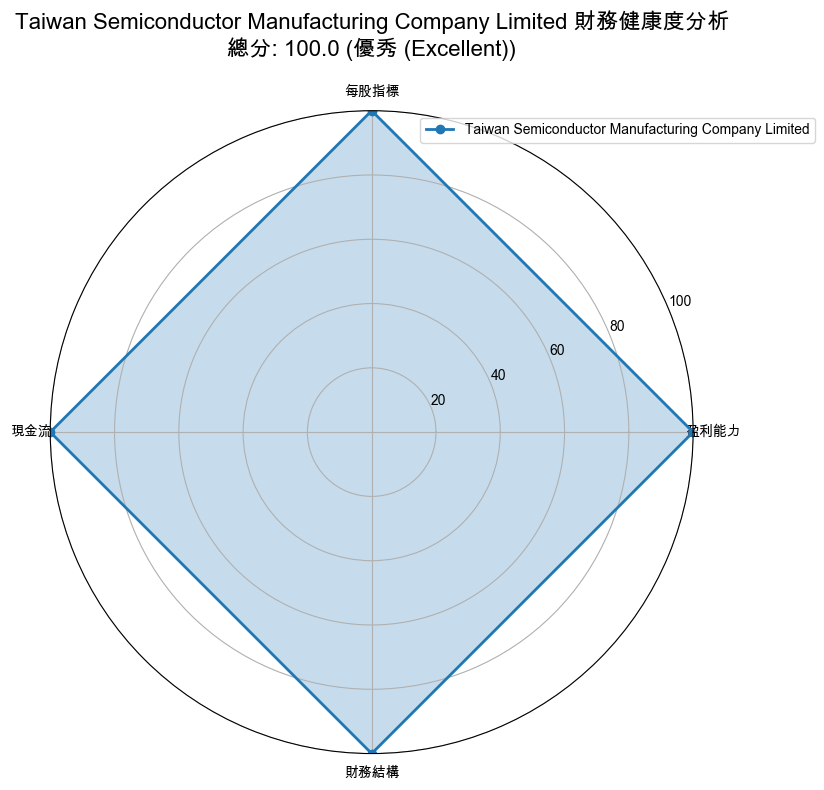

In [6]:
# 設定股票代碼
stock_code = "2330.TW"

# 獲取財務數據
print(f"正在獲取 {stock_code} 的財務數據...")
financial_data = get_company_financial_data(stock_code)

if financial_data:
    # 計算健康度指標
    print("計算財務健康度指標...")
    health_metrics = calculate_health_metrics(financial_data)
    
    # 計算健康度評分
    print("計算健康度評分...")
    health_scores = calculate_health_score(health_metrics)
    
    # 顯示結果
    display_health_summary(health_metrics, health_scores)
    
    # 創建雷達圖
    create_health_radar_chart(health_metrics, health_scores)
    
else:
    print(f"無法獲取 {stock_code} 的數據")

### 多公司比較分析

In [7]:
def compare_multiple_companies(stock_codes):
    """
    比較多家公司的財務健康度
    
    Parameters:
    stock_codes (list): 股票代碼列表
    """
    
    results = []
    
    for code in stock_codes:
        print(f"\n正在分析 {code}...")
        financial_data = get_company_financial_data(code)
        
        if financial_data:
            metrics = calculate_health_metrics(financial_data)
            scores = calculate_health_score(metrics)
            
            results.append({
                'stock_code': code,
                'company_name': metrics.get('company_name', code),
                'total_score': scores.get('total_score', 0),
                'health_grade': scores.get('health_grade', 'N/A'),
                'profitability_score': scores.get('profitability_score', 0),
                'per_share_score': scores.get('per_share_score', 0),
                'cashflow_score': scores.get('cashflow_score', 0),
                'financial_structure_score': scores.get('financial_structure_score', 0),
                'metrics': metrics,
                'scores': scores
            })
    
    # 創建比較表格
    if results:
        df_comparison = pd.DataFrame(results)
        df_comparison = df_comparison.sort_values('total_score', ascending=False)
        
        print(f"\n{'='*120}")
        print("📊 多公司財務健康度比較排行榜")
        print(f"{'='*120}")
        
        for i, row in df_comparison.iterrows():
            rank = df_comparison.index.get_loc(i) + 1
            print(f"{rank:2d}. {row['company_name']:20s} ({row['stock_code']:8s}) - "
                  f"總分: {row['total_score']:5.1f} ({row['health_grade']})")
        
        # 創建比較雷達圖
        fig, axes = plt.subplots(2, 2, figsize=(16, 12), subplot_kw=dict(projection='polar'))
        axes = axes.flatten()
        
        categories = ['盈利能力', '每股指標', '現金流', '財務結構']
        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
        angles += angles[:1]
        
        for idx, (i, row) in enumerate(df_comparison.head(4).iterrows()):
            if idx < 4:
                values = [
                    row['profitability_score'],
                    row['per_share_score'],
                    row['cashflow_score'],
                    row['financial_structure_score']
                ]
                values += values[:1]
                
                ax = axes[idx]
                ax.plot(angles, values, 'o-', linewidth=2)
                ax.fill(angles, values, alpha=0.25)
                ax.set_xticks(angles[:-1])
                ax.set_xticklabels(categories)
                ax.set_ylim(0, 100)
                ax.set_yticks([20, 40, 60, 80, 100])
                ax.set_title(f"{row['company_name']}\n總分: {row['total_score']:.1f}", 
                           size=12, weight='bold', pad=15)
                ax.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        return df_comparison
    
    return None

### 執行多公司比較分析


正在分析 2330.TW...

正在分析 2317.TW...

正在分析 2454.TW...

正在分析 2881.TW...

📊 多公司財務健康度比較排行榜
 1. Taiwan Semiconductor Manufacturing Company Limited (2330.TW ) - 總分: 100.0 (優秀 (Excellent))
 2. MediaTek Inc.        (2454.TW ) - 總分:  84.3 (優秀 (Excellent))
 3. Fubon Financial Holding Co., Ltd. (2881.TW ) - 總分:  82.7 (優秀 (Excellent))
 4. Hon Hai Precision Industry Co., Ltd. (2317.TW ) - 總分:  72.8 (良好 (Good))


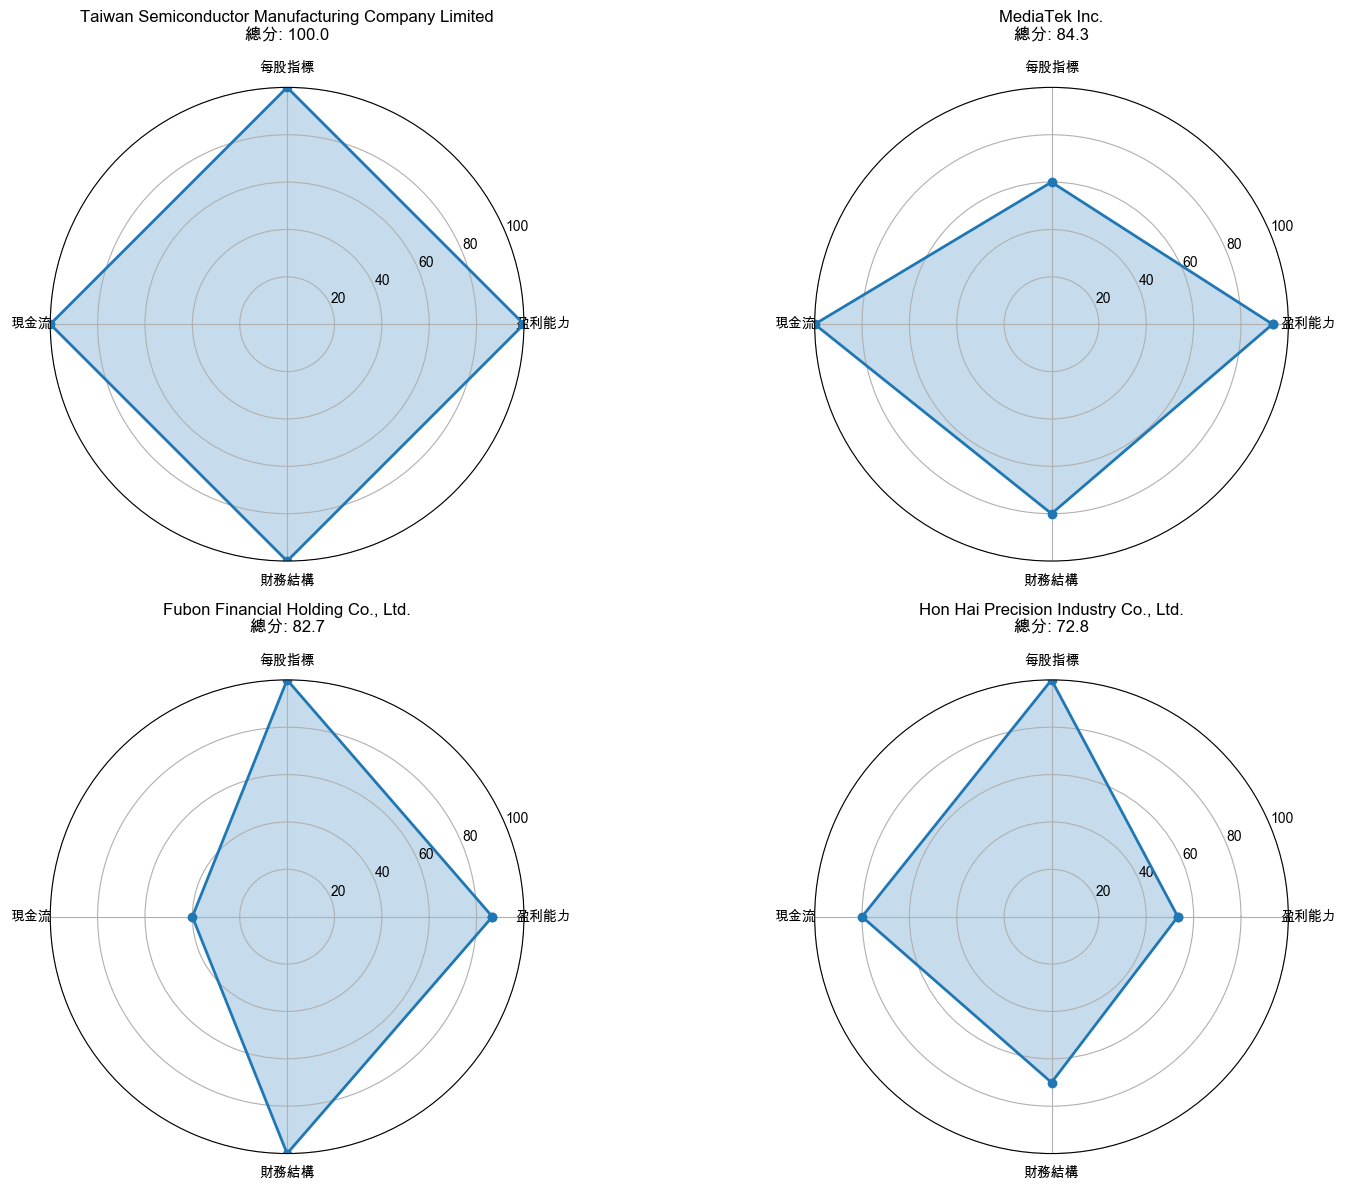

In [8]:
# 選擇要比較的股票 (台灣知名大型股)
comparison_stocks = [
    "2330.TW",  # 台積電
    "2317.TW",  # 鴻海
    "2454.TW",  # 聯發科
    "2881.TW",  # 富邦金
    # "1301.TW",  # 台塑
    # "1303.TW",  # 南亞
]

# 執行比較分析
comparison_results = compare_multiple_companies(comparison_stocks)

## 進階分析功能

### 產業健康度分析

In [10]:
def industry_health_analysis(stock_codes):
    """
    產業健康度分析
    
    Parameters:
    stock_codes (list): 同產業股票代碼列表
    """
    
    industry_data = []
    
    for code in stock_codes:
        financial_data = get_company_financial_data(code)
        if financial_data:
            metrics = calculate_health_metrics(financial_data)
            scores = calculate_health_score(metrics)
            
            industry_data.append({
                'stock_code': code,
                'company_name': metrics.get('company_name', code),
                'sector': metrics.get('sector', 'Unknown'),
                'total_score': scores.get('total_score', 0),
                'revenue_growth': metrics.get('revenue_growth_rate', 0),
                'gross_margin': metrics.get('gross_margin', 0),
                'net_margin': metrics.get('net_margin', 0),
                'roe': metrics.get('roe', 0),
                'debt_ratio': metrics.get('debt_ratio', 0)
            })
    
    if industry_data:
        df_industry = pd.DataFrame(industry_data)
        
        # 產業統計
        print(f"\n{'='*80}")
        print(f"🏭 產業健康度統計分析 ({df_industry['sector'].iloc[0] if len(df_industry) > 0 else 'Unknown'})")
        print(f"{'='*80}")
        
        print(f"\n📊 產業平均指標:")
        print(f"  平均健康度得分: {df_industry['total_score'].mean():.1f}")
        print(f"  平均營收成長率: {df_industry['revenue_growth'].mean():.2f}%")
        print(f"  平均毛利率: {df_industry['gross_margin'].mean():.2f}%")
        print(f"  平均淨利率: {df_industry['net_margin'].mean():.2f}%")
        print(f"  平均ROE: {df_industry['roe'].mean():.2f}%")
        print(f"  平均負債比: {df_industry['debt_ratio'].mean():.2f}%")
        
        print(f"\n🏆 產業排名:")
        df_sorted = df_industry.sort_values('total_score', ascending=False)
        for i, row in df_sorted.iterrows():
            rank = df_sorted.index.get_loc(i) + 1
            print(f"  {rank}. {row['company_name']} - {row['total_score']:.1f}分")
        
        # 創建產業對比圖
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 健康度得分對比
        axes[0,0].bar(range(len(df_industry)), df_industry['total_score'])
        axes[0,0].set_title('健康度總分對比')
        axes[0,0].set_xticks(range(len(df_industry)))
        axes[0,0].set_xticklabels([name[:6] + '...' if len(name) > 6 else name 
                                   for name in df_industry['company_name']], rotation=45)
        
        # 營收成長率對比
        axes[0,1].bar(range(len(df_industry)), df_industry['revenue_growth'])
        axes[0,1].set_title('營收成長率對比 (%)')
        axes[0,1].set_xticks(range(len(df_industry)))
        axes[0,1].set_xticklabels([name[:6] + '...' if len(name) > 6 else name 
                                   for name in df_industry['company_name']], rotation=45)
        
        # 毛利率對比
        axes[0,2].bar(range(len(df_industry)), df_industry['gross_margin'])
        axes[0,2].set_title('毛利率對比 (%)')
        axes[0,2].set_xticks(range(len(df_industry)))
        axes[0,2].set_xticklabels([name[:6] + '...' if len(name) > 6 else name 
                                   for name in df_industry['company_name']], rotation=45)
        
        # 淨利率對比
        axes[1,0].bar(range(len(df_industry)), df_industry['net_margin'])
        axes[1,0].set_title('淨利率對比 (%)')
        axes[1,0].set_xticks(range(len(df_industry)))
        axes[1,0].set_xticklabels([name[:6] + '...' if len(name) > 6 else name 
                                   for name in df_industry['company_name']], rotation=45)
        
        # ROE對比
        axes[1,1].bar(range(len(df_industry)), df_industry['roe'])
        axes[1,1].set_title('ROE對比 (%)')
        axes[1,1].set_xticks(range(len(df_industry)))
        axes[1,1].set_xticklabels([name[:6] + '...' if len(name) > 6 else name 
                                   for name in df_industry['company_name']], rotation=45)
        
        # 負債比對比
        axes[1,2].bar(range(len(df_industry)), df_industry['debt_ratio'])
        axes[1,2].set_title('負債比對比 (%)')
        axes[1,2].set_xticks(range(len(df_industry)))
        axes[1,2].set_xticklabels([name[:6] + '...' if len(name) > 6 else name 
                                   for name in df_industry['company_name']], rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        return df_industry
    
    return None

## 總結與反思

### 研究成果

1. **完整的評估體系**: 建立了涵蓋盈利能力、每股指標、現金流和財務結構的四大維度評估系統

2. **量化評分機制**: 設計了基於台股市場經驗值的評分標準，提供客觀的健康度評估

3. **視覺化分析**: 透過雷達圖和比較圖表，直觀呈現公司財務狀況

4. **多維度比較**: 支援單一公司分析、多公司比較和產業分析等不同應用場景

### 指標權重設計邏輯

- **盈利能力 (40%)**: 最重要的指標，反映公司的核心競爭力
- **每股指標 (25%)**: 直接關係投資回報，對投資者重要性高
- **現金流 (20%)**: 反映公司實際營運狀況和償債能力
- **財務結構 (15%)**: 評估公司財務穩健度和風險控制能力

### 應用建議

1. **投資篩選**: 可作為初步篩選工具，快速識別財務健康的投資標的
2. **風險控制**: 透過健康度監控，及早發現投資組合中的風險股票
3. **同業比較**: 在同產業中挑選最具競爭力的公司
4. **定期監控**: 建議每季更新數據，追蹤公司健康度變化趨勢

### 限制與改進方向

1. **數據時效性**: yfinance 數據可能有延遲，建議搭配其他即時數據源
2. **產業差異**: 不同產業的評分標準應該要有所調整
3. **定性因素**: 目前僅考慮量化指標，未納入管理層品質、市場地位等定性因素
4. **預測能力**: 可加入趨勢分析和預測模型，提升前瞻性

### 後續發展

1. **動態權重**: 根據市場環境和產業特性動態調整權重
2. **預警系統**: 建立財務惡化的早期預警機制
3. **回測驗證**: 透過歷史數據驗證評分系統的預測準確性
4. **自動化報告**: 開發定期自動化分析報告功能

In [ ]:
def compare_scoring_methods(stock_code):
    """
    比較產業調整評分 vs 通用評分的差異
    
    Parameters:
    stock_code (str): 股票代碼
    """
    
    print(f"📊 {stock_code} 評分方法比較分析")
    print("=" * 60)
    
    # 獲取財務數據
    financial_data = get_company_financial_data(stock_code)
    if not financial_data:
        print("❌ 無法獲取財務數據")
        return
    
    # 計算健康度指標
    metrics = calculate_health_metrics(financial_data)
    company_name = metrics.get('company_name', stock_code)
    sector = metrics.get('sector', 'Unknown')
    
    print(f"🏢 公司: {company_name}")
    print(f"🏭 產業: {sector}")
    print()
    
    # 通用評分
    print("📈 通用評分結果:")
    generic_scores = calculate_health_score(metrics, use_industry_adjustment=False)
    
    # 產業調整評分  
    print("\n🎯 產業調整評分結果:")
    industry_scores = calculate_health_score(metrics, use_industry_adjustment=True)
    
    # 比較結果
    print(f"\n📊 評分比較:")
    print(f"  通用評分:   {generic_scores['total_score']:.1f} ({generic_scores['health_grade']})")
    print(f"  產業調整:   {industry_scores['total_score']:.1f} ({industry_scores['health_grade']})")
    print(f"  分數差異:   {industry_scores['total_score'] - generic_scores['total_score']:+.1f}")
    
    # 各維度比較
    print(f"\n🔍 各維度評分比較:")
    dimensions = ['profitability_score', 'per_share_score', 'cashflow_score', 'financial_structure_score']
    dim_names = ['盈利能力', '每股指標', '現金流', '財務結構']
    
    for dim, name in zip(dimensions, dim_names):
        generic_dim = generic_scores.get(dim, 0)
        industry_dim = industry_scores.get(dim, 0)
        diff = industry_dim - generic_dim
        print(f"  {name:8s}: {generic_dim:5.1f} → {industry_dim:5.1f} ({diff:+5.1f})")
    
    # 權重比較
    print(f"\n⚖️ 權重使用:")
    generic_weights = {
        'profitability_score': 0.40,
        'per_share_score': 0.25,
        'cashflow_score': 0.20,
        'financial_structure_score': 0.15
    }
    industry_weights = industry_scores.get('weights_used', generic_weights)
    
    for dim, name in zip(dimensions, dim_names):
        generic_w = generic_weights.get(dim, 0) * 100
        industry_w = industry_weights.get(dim, 0) * 100
        print(f"  {name:8s}: {generic_w:5.1f}% → {industry_w:5.1f}%")
    
    return generic_scores, industry_scores

# 測試範例 - 不同產業的公司
test_stocks = [
    "2330.TW",  # 台積電 (科技業)
    "2881.TW",  # 富邦金 (金融業)
]

for stock in test_stocks:
    compare_scoring_methods(stock)
    print("\\n" + "="*80 + "\\n")

### 產業調整 vs 通用評分比較

In [ ]:
# 展示各產業的財務特性
print("🏭 台灣各產業財務特性概覽")
print("=" * 80)

# 使用產業分析器展示特性
industries = ['科技業', '金融業', '傳統製造業', '零售業', '公用事業']

for industry in industries:
    profile = industry_analyzer.get_industry_profile(industry)
    if profile:
        print(f"\n📊 {industry}")
        print(f"   描述: {profile.get('description', 'N/A')}")
        print(f"   代表公司: {', '.join(profile.get('typical_companies', []))}")
        
        # 顯示財務特性
        chars = profile.get('characteristics', {})
        if chars:
            print("   財務特性:")
            for metric, data in chars.items():
                if isinstance(data, dict) and 'typical' in data:
                    print(f"     • {metric}: {data.get('typical', 'N/A')}% - {data.get('explanation', 'N/A')}")

print(f"\n{'='*80}")
print("💡 提示: 系統會根據公司所屬產業自動調整評分標準和權重")

### 產業特性分析展示

## 🏭 產業調整功能應用

In [ ]:
# 建立產業財務特性分析框架
import pandas as pd
import numpy as np

# 定義各產業的典型財務特性
industry_characteristics = {
    "科技業": {
        "description": "台積電、聯發科等半導體與科技硬體公司",
        "typical_companies": ["2330.TW", "2454.TW", "2382.TW", "3008.TW"],
        "financial_profile": {
            "gross_margin": {"range": "40-60%", "explanation": "高技術門檻與專利保護"},
            "net_margin": {"range": "15-25%", "explanation": "研發費用高但產品附加價值高"},
            "debt_ratio": {"range": "15-30%", "explanation": "現金充裕，負債比相對較低"},
            "roe": {"range": "15-25%", "explanation": "高技術壁壘帶來穩定回報"},
            "roa": {"range": "8-15%", "explanation": "資產使用效率較高"},
            "revenue_growth": {"range": "5-20%", "explanation": "週期性強，受景氣影響大"},
            "cash_flow": {"range": "強勁", "explanation": "現金轉換週期短，收款迅速"}
        }
    },
    
    "金融業": {
        "description": "銀行、保險、證券等金融服務業",
        "typical_companies": ["2881.TW", "2882.TW", "2886.TW", "2892.TW"],
        "financial_profile": {
            "gross_margin": {"range": "70-85%", "explanation": "利差收入為主，毛利率概念不同"},
            "net_margin": {"range": "25-40%", "explanation": "營業費用相對固定"},
            "debt_ratio": {"range": "85-95%", "explanation": "存款負債為主要資金來源"},
            "roe": {"range": "8-15%", "explanation": "穩定但成長性有限"},
            "roa": {"range": "0.8-1.5%", "explanation": "資產規模龐大，報酬率相對較低"},
            "revenue_growth": {"range": "3-8%", "explanation": "穩定成長，受利率環境影響"},
            "cash_flow": {"range": "穩定", "explanation": "現金流穩定但結構特殊"}
        }
    },
    
    "傳統製造業": {
        "description": "台塑、中鋼等石化、鋼鐵製造業",
        "typical_companies": ["1301.TW", "1303.TW", "2002.TW", "2105.TW"],
        "financial_profile": {
            "gross_margin": {"range": "8-20%", "explanation": "競爭激烈，毛利率相對較低"},
            "net_margin": {"range": "3-8%", "explanation": "成本控制為關鍵競爭力"},
            "debt_ratio": {"range": "40-60%", "explanation": "資本密集，需要大量資金投入"},
            "roe": {"range": "5-12%", "explanation": "週期性強，獲利波動大"},
            "roa": {"range": "3-8%", "explanation": "資產周轉率較低"},
            "revenue_growth": {"range": "-5-10%", "explanation": "高度週期性，受原物料價格影響"},
            "cash_flow": {"range": "波動大", "explanation": "庫存週期長，現金流波動性大"}
        }
    },
    
    "零售業": {
        "description": "統一超、全家等零售通路業",
        "typical_companies": ["2912.TW", "5903.TW", "2915.TW", "9945.TW"],
        "financial_profile": {
            "gross_margin": {"range": "25-35%", "explanation": "通路服務費與自有品牌貢獻"},
            "net_margin": {"range": "3-8%", "explanation": "人事與租金成本高"},
            "debt_ratio": {"range": "30-50%", "explanation": "應付帳款週轉快"},
            "roe": {"range": "12-20%", "explanation": "資產周轉率高"},
            "roa": {"range": "8-15%", "explanation": "坪效管理為關鍵"},
            "revenue_growth": {"range": "3-8%", "explanation": "穩定成長，受消費力影響"},
            "cash_flow": {"range": "穩定", "explanation": "現金收付，週轉快速"}
        }
    },
    
    "公用事業": {
        "description": "台電、中華電信等公用事業",
        "typical_companies": ["3045.TW", "2412.TW", "9904.TW", "1434.TW"],
        "financial_profile": {
            "gross_margin": {"range": "30-50%", "explanation": "穩定的服務費用收入"},
            "net_margin": {"range": "8-15%", "explanation": "受管制定價，獲利穩定"},
            "debt_ratio": {"range": "25-45%", "explanation": "穩定現金流支撐適度負債"},
            "roe": {"range": "8-15%", "explanation": "穩定但成長性有限"},
            "roa": {"range": "3-8%", "explanation": "資產密集但使用效率穩定"},
            "revenue_growth": {"range": "1-5%", "explanation": "成長性低但穩定"},
            "cash_flow": {"range": "非常穩定", "explanation": "現金流可預測性高"}
        }
    }
}

# 顯示產業特性概覽
print("🏭 台灣各產業財務特性分析")
print("=" * 80)

for industry, data in industry_characteristics.items():
    print(f"\n📊 {industry}")
    print(f"   代表公司: {data['description']}")
    print(f"   典型財務特性:")
    
    for metric, info in data['financial_profile'].items():
        if metric == "gross_margin":
            print(f"     • 毛利率: {info['range']} - {info['explanation']}")
        elif metric == "net_margin":
            print(f"     • 淨利率: {info['range']} - {info['explanation']}")
        elif metric == "debt_ratio":
            print(f"     • 負債比: {info['range']} - {info['explanation']}")
        elif metric == "roe":
            print(f"     • ROE: {info['range']} - {info['explanation']}")
        elif metric == "roa":
            print(f"     • ROA: {info['range']} - {info['explanation']}")
        elif metric == "revenue_growth":
            print(f"     • 營收成長: {info['range']} - {info['explanation']}")
        elif metric == "cash_flow":
            print(f"     • 現金流: {info['range']} - {info['explanation']}")